In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_2d, plot_2d_distribution, kl_estimate_with_mc, compute_variational_posterior
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

# Problem 1

The KL between q and p is 53.861 nats.


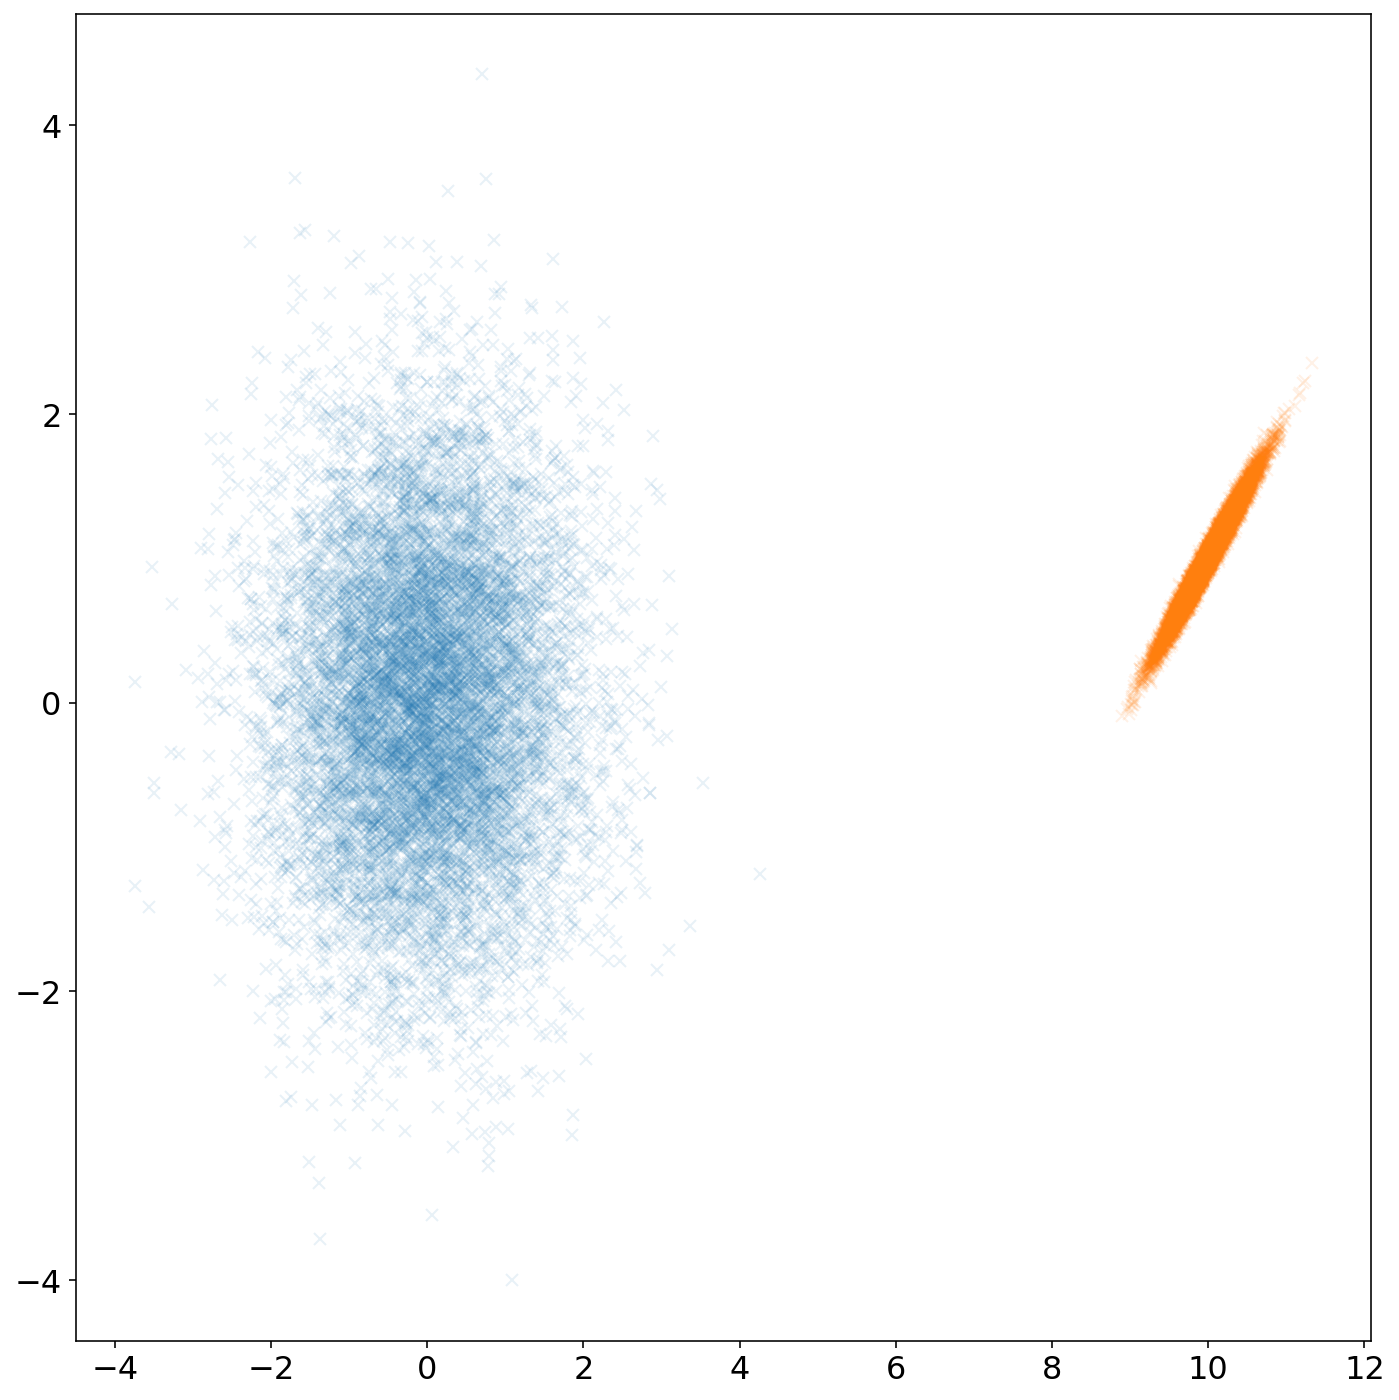

In [8]:
torch.manual_seed(100)

q_loc = [10., 1.]
q_covar = [[0.1, 0.099], [0.099, 0.1]]

p_loc = [0., 0.]
p_var = 1.

q = dist.MultivariateNormal(loc=torch.tensor(q_loc), covariance_matrix = 1. * torch.tensor(q_covar))
p = dist.MultivariateNormal(loc=torch.tensor(p_loc), covariance_matrix = p_var * torch.eye(2))

z_sample = q.sample()

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=10000).mean()
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================
p_samples = p.sample((10000,))
q_samples = q.sample((10000,))
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=0.1)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=0.1)

f.tight_layout()


In [9]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

In [10]:
coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler

In [11]:
num_compressed_samples = 1
omega = 5
initial_seed = 10
beamwidth = 1
epsilon = 0.02
alpha = 1./p_var
var_post = compute_variational_posterior(q)
enc = Encoder(var_post,
             initial_seed,
             coding_sampler,
             selection_sampler,
             auxiliary_posterior,
             omega,
             beamwidth=beamwidth,
             epsilon=epsilon,
             prior_var=1./alpha)
    
    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
z, idx = enc.run_encoder()

In [12]:
enc.auxiliary_posterior.coding_sampler.auxiliary_vars

tensor([0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
        0.0833, 0.0833, 0.0833])

In [13]:
var_traj = enc.selected_samples[0]

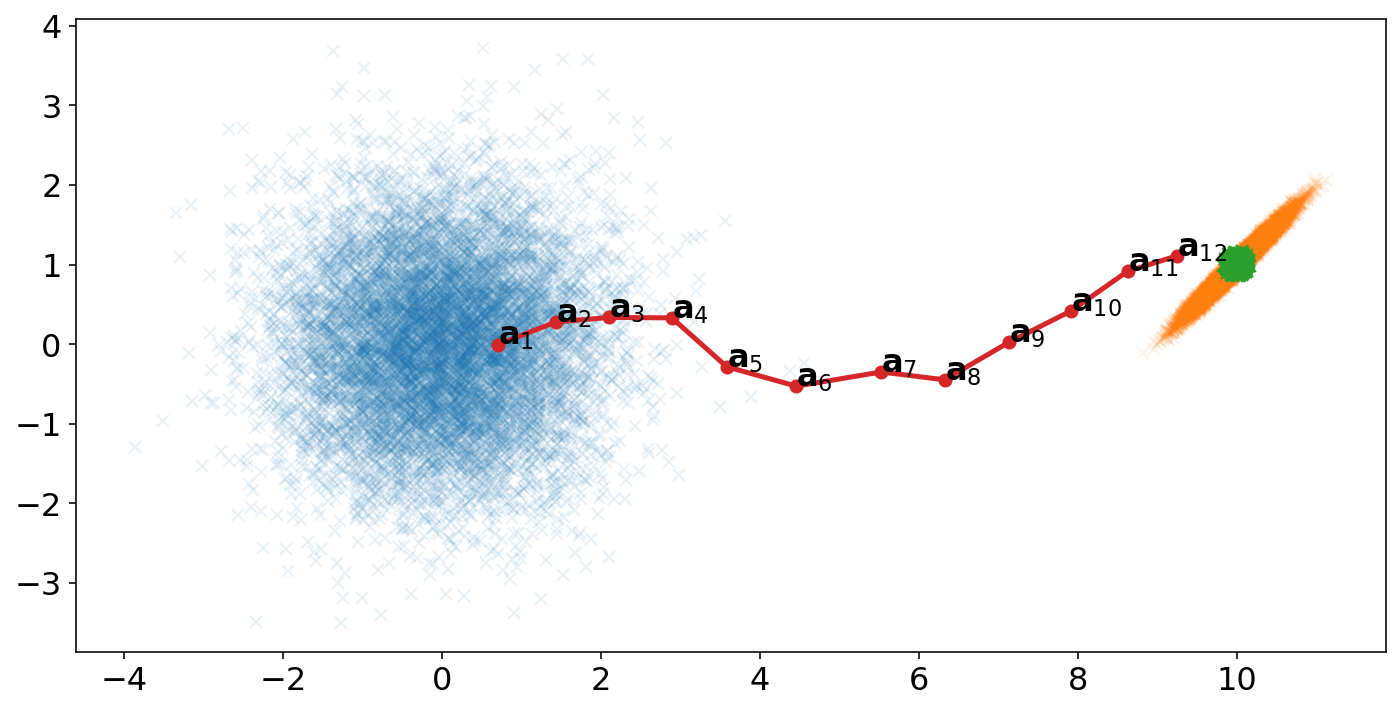

In [14]:
q_samples = q.sample((10000,))
p_samples = p.sample((10000,))
var_samples = var_post.sample((10000,))
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=0.1)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=0.1)
ax.plot(var_samples[:,0], var_samples[:,1], 'x', alpha=1.)
ax.set_aspect('equal', adjustable='box')
f.tight_layout()
plot_running_sum_2d(var_traj, plot_index_labels=True)

In [15]:
from rec.beamsearch.Coders.Encoder import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler

In [16]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler

In [42]:
num_compressed_samples = 1
omega = 5
initial_seed = 10
beamwidth = 1
epsilon = 0.02
alpha = 1./p_var
enc = Encoder(q,
             initial_seed,
             coding_sampler,
             selection_sampler,
             auxiliary_posterior,
             omega,
             n_samples_from_target=25,
             beamwidth=beamwidth,
             epsilon=epsilon,
             prior_var=1./alpha,
             total_kl=total_kl)
    
    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
z, idx = enc.run_encoder()

In [43]:
emp_traj = enc.selected_samples[0]

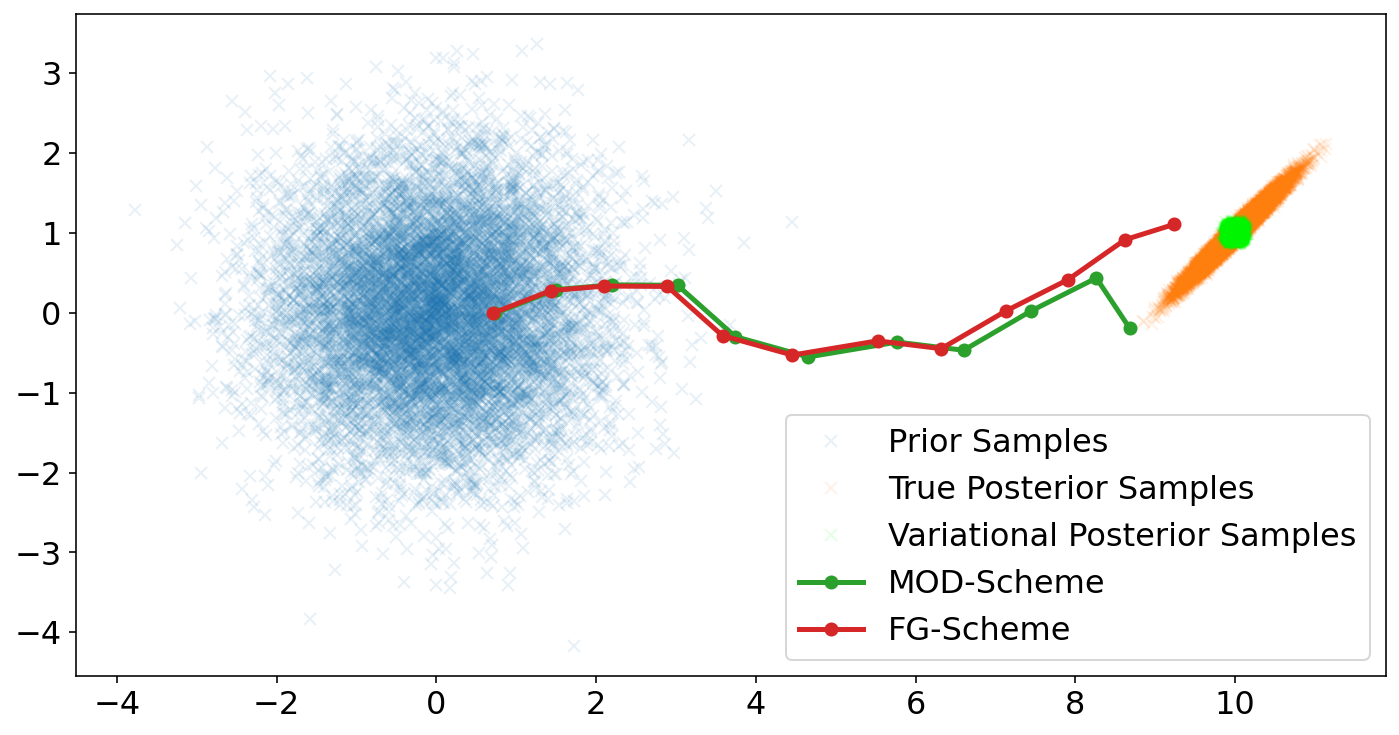

In [54]:
q_samples = q.sample((10000,))
p_samples = p.sample((10000,))
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=1)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=1)
ax.plot(var_samples[:,0], var_samples[:,1], 'x', alpha=1., color='lime')
ax.set_aspect('equal', adjustable='box')
plot_running_sum_2d(emp_traj, plot_index_labels=False)
plot_running_sum_2d(var_traj, plot_index_labels=False)
ax.legend(['Prior Samples', r'True Posterior Samples', 'Variational Posterior Samples', 'MOD-Scheme', 'FG-Scheme'], fontsize=16)
ax.set_xlabel(r"$\mathbf{z}_1$")
ax.set_ylabel(r"$\mathbf{z}_2$")
f.tight_layout()
#f.savefig("Figures/Thesis/Var_vs_Emp_Traj.pdf", bbox_inches='tight')